Total num of samples:  1052
Number of examples per label: 381
Example file tensor:  tf.Tensor(b'C:\\Users\\rclendening\\researchData\\RedVox_Training\\Mavic_Pro\\  (225).wav', shape=(), dtype=string)
['IF1200' 'Matrice_600' 'Mavic_Pro' 'Noise' 'Phantom_4_Pro_V2']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 401, 1)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 195, 32)           384       
                                                                 
 batch_normalization (BatchN  (None, 195, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 195, 32)           0         
                                                             

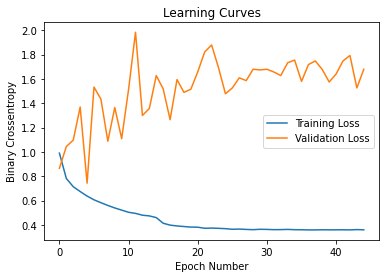

In [1]:
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

features = []
labels = []
dataset_path: str = "C:\\Users\\rclendening\\researchData\\RedVox_Training"
data_dir = pathlib.Path(dataset_path)
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "IF1200": [1, 0, 0, 0, 0],
    "Matrice_600": [0, 1, 0, 0, 0],
    "Mavic_Pro": [0, 0, 1, 0, 0],
    "Phantom_4_Pro_V2": [0, 0, 0, 1, 0],
    "Noise": [0, 0, 0, 0, 1]
}
droneCountDict = {  # One hot encoding for labels
    "IF1200": 0,
    "Matrice_600": 1,
    "Mavic_Pro": 2,
    "Phantom_4_Pro_V2": 3,
    "Noise": 4
}
dataCount = [0, 0, 0, 0, 0]
drones = np.array(tf.io.gfile.listdir(str(data_dir)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
train_files = filenames
# x = round((len(train_files) / 5))
# train_files = train_files[:x]
print("Total num of samples: ", num_samples)
print("Number of examples per label:", len(tf.io.gfile.listdir(str(data_dir / drones[0]))))
print("Example file tensor: ", filenames[0])
print(drones)
chunk_size=0.1
# test_file = tf.io.read_file(
#     "C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\IF1200\\d301sA1r01p0120210823_6.wav")
# test_audio, _ = tf.audio.decode_wav(contents=test_file)
# test_audio.shape


def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)


def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]


def split_audio(waveData, labelName, sampleFreq, frame_duration):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = []
    label = []
    # middle third of data
    duration = waveData.shape[0]
    startTime = np.round(duration / 3)
    endTime = np.round(duration * 2 / 3)
    frame_dur = frame_duration * sampleFreq
    t1 = startTime
    t2 = t1 + frame_dur
    frame_dur = int(frame_dur)
    t1 = int(t1)
    t2 = int(t2)
    if waveData.shape[0] != 0:
        while t2 < endTime:
            split = waveData[t1:t2]
            t1 = t2
            t2 = t2 + frame_dur
            split = tf.reshape(split, frame_dur)
            split = PSD_log(split, frame_dur)
            features.append(split)
            # label.append(labelName)
            dataCount[droneCountDict[labelName]] += 1
            label.append(droneDict[labelName])  # one hot encoding
    return features, label

def split_test_audio(waveData, labelName, sampleFreq, frame_duration):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired (in seconds)
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = []
    label = []
    # middle third of data
    duration = waveData.shape[0]
    startTime = 0
    endTime = startTime+duration
    frame_dur = frame_duration * sampleFreq
    t1 = startTime
    t2 = t1 + frame_dur
    frame_dur = int(round(frame_dur))
    t1 = int(t1)
    t2 = int(t2)
    if waveData.shape[0] != 0:
        while t2 < endTime:
            split = waveData[t1:t2]
            t1 = t2
            t2 = t2 + frame_dur
            split = tf.reshape(split, frame_dur)
            split = PSD_log(split, frame_dur)
            features.append(split)
            # label.append(labelName)
            label.append(labelName)  # one hot encoding
    return features, label

def create_dataset(train_files):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in train_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if sampleRate != 8000:
            break;
        x = str(x)
        label = x.split('\\')
        label = label[10]
        newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
        newFeats, newLabs = split_audio(newData, label, int(sampleRate), chunk_size)
        features.extend(newFeats)
        labels.extend(newLabs)

    return features, labels

def create_test_dataset(test_files):
    '''
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in test_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        x = str(x)
        label = x.split('\\')
        label = label[6]
        test_audio = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
        newFeats, newLabs = split_test_audio(test_audio, label, int(sampleRate), chunk_size)
        features.extend(newFeats)
        labels.extend(newLabs)
        i = i + 1

    return features, labels

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def PSD_log(waveform, length):
    input_len = length
    waveform = waveform[:input_len]
    logPSD = []
    f_dum, PSD = signal.welch(waveform, fs=8000, window='hann',
                                  nperseg=input_len, average='mean')
    logPSD=np.log(PSD + np.finfo(float).eps)
    #logPSD.append(np.log(PSD + np.finfo(float).eps))
    return PSD

def grabTrainingSamples(n, trainingData):
    IFCount = 0
    matriceCount = 0
    phantomCount = 0
    mavicCount = 0
    noiseCount = 0
    evenTrainingData = []
    evenLabelData = []
    for i in range(len(labels)):
        lab = trainingData[i][1]
        if lab == [1, 0, 0, 0, 0] and IFCount < n:
            IFCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
        elif lab == [0, 1, 0, 0, 0] and matriceCount < n:
            matriceCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
        elif lab == [0, 0, 1, 0, 0] and phantomCount < n:
            phantomCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
        elif lab == [0, 0, 0, 1, 0] and mavicCount < n:
            mavicCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
        elif lab == [0, 0, 0, 0, 1] and noiseCount < n:
            noiseCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
    return evenTrainingData, evenLabelData
def pitchShifter(data, sr, n_steps):
    return pitch_shift(data, sr=sr, n_steps=n_steps)


Fs = 8000
numFeat = int((Fs*chunk_size*0.5)+1) #COULD BE SOURCE OF ERROR
features, labels = create_dataset(train_files)
newSet = list(zip(features, labels))
random.seed()
random.shuffle(newSet)  # Ensure data is mixed together
n = np.min(dataCount)  # Ensure data is symmetric (aka even amounts of training data for all classes)
# features, labels = grabTrainingSamples(n, features, labels)
features, labels = grabTrainingSamples(n, newSet)

trainFeatures, testFeatures, trainTargets, testTargets = train_test_split(features, labels, test_size=0.2,
                                                                          random_state=25)
# Standardize features
trainFeatures = np.asarray(trainFeatures)
trainTargets = np.asarray(trainTargets)
mean = trainFeatures.mean(axis=0)
trainFeatures -= mean
std = trainFeatures.std(axis=0)
trainFeatures /= std
trainFeatures = np.reshape(trainFeatures,
                           (len(trainFeatures), numFeat, 1))
testFeatures = np.asarray(testFeatures)
testTargets = np.asarray(testTargets)
testFeatures -= mean
testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))

# Probabilistic range regression network
# def NLL(y, distr):  #Loss function
#    return -distr.log_prob(y)
# def normal_sp(params):  #Distribution function
#    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))  # Both mean and variance parameters are learnable
# inputs = Input(shape=(numFeat, 1))
# hidden = BatchNormalization()(inputs)
# hidden = Conv1D(64, 12, strides=2, use_bias=False, name='conv_1')(hidden)
# hidden = Conv1D(128, 12, strides=2, use_bias=False, name='conv_2')(hidden)
# #hidden = MaxPooling1D()(hidden)
# hidden = Dropout(0.25)(hidden)
# hidden = Flatten()(hidden)
# hidden = Dropout(0.1)(hidden)
# hidden = Flatten()(hidden)
# dist = Dense(5, activation='softmax', name='dense_2')(hidden)
inputs = Input(shape=(numFeat, 1))
hidden = Conv1D(32, 12, strides=2, use_bias=False, name='conv_1')(inputs)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = SeparableConv1D(32, 6, strides=2, use_bias=False,
                         name='conv_2')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = SeparableConv1D(32, 3, strides=2, use_bias=False,
                         name='conv_3')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Flatten()(hidden)
hidden = Dropout(0.1)(hidden)
hidden = Dense(864, activation='relu', name='dense_1')(hidden)  # 896, 864, 928
hidden = Dropout(0.1)(hidden)
dist = Dense(len(dataCount), activation='sigmoid', name='dense_2')(hidden)
network = Model(inputs=inputs, outputs=dist)
network.summary()
network.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto')
history = network.fit(trainFeatures, trainTargets,
                      epochs=50,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
# if retrain:
#     call2 = ModelCheckpoint(filepath=(dirWeights + weights_save),
#                             verbose=1, monitor='val_loss', save_best_only=True)
#     reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                  verbose=1, patience=10, mode='auto')
#     early = EarlyStopping(monitor='val_loss', min_delta=1e-4,
#                           patience=40, mode='auto')
#     history = network.fit(trainFeatures, trainTargets,
#                           epochs=1000,
#                           batch_size=32,
#                           shuffle=True,
#                           validation_split=0.2,
#                           callbacks=[reduceLR, early, call2])
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Learning Curves')
#     plt.legend(['Training Loss', 'Validation Loss'])
#     plt.ylabel('Binary Crossentropy')
#     plt.xlabel('Epoch Number')
#     plt.show()
#     network.load_weights(dirWeights + weights_load, by_name=True)
# else:
#     network.load_weights(dirWeights + weights_load, by_name=True)

In [28]:
y_pred = np.argmax(network.predict(testFeatures), axis=1)
y_predict=[]
for x in y_pred:
    ans=np.zeros(5)
    ans[x]=1
    y_predict.append(ans)
y_true = testTargets
Sum=0
for x in range(len(y_predict)):
    if np.array_equiv(y_predict[x].tolist(),y_true[x]):
        Sum+=1
Matrice=0
IF=0
Noise=0
Mavic=0
Phantom=0
for x in range(len(y_predict)):
    if y_predict[x].tolist()==[1,0,0,0,0]:
        IF+=1
    if y_predict[x].tolist()==[0,1,0,0,0]:
        Matrice+=1
    if y_predict[x].tolist()==[0,0,1,0,0]:
        Mavic+=1
    if y_predict[x].tolist()==[0,0,0,1,0]:
        Phantom+=1
    if y_predict[x].tolist()==[0,0,0,0,1]:
        Noise+=1
#Sum=sum(y_predict == y_true)
#list=[IF,Matrice,Mavic,Noise,Phantom]
#print(np.max(list))
test_acc = Sum/ len(y_true)
print(f'Test set accuracy:', test_acc)

Test set accuracy: 0.7144984546220848


Testing with cell phone scenario. Achieving 0% accuracy because although sampled at same frequency, there must be some cell phone artifacts in the noise data that is making all cell phone data be seen as noise. After further evaluation, taking the logPSD causes the training data to potentially overfit(?). When PSD is calculated without log, the algorithm can accurately predict the drone when using cell phones as test data. Further investigation will be required to further refine and determine.

In [158]:




def create_test_dataset(test_files):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    i = 0
    features = []
    labels = []
    for x in test_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        x = str(x)
        label = x.split('\\')
        label = label[6]
        test_audio = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
        newFeats, newLabs = split_test_audio(test_audio, label, int(sampleRate), chunk_size)
        features.extend(newFeats)
        labels.extend(newLabs)
        i = i + 1

    return features, labels

testFeatures,testTargets =create_test_dataset(["C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_1-3.wav","C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_5-2.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_5-3.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_6-2.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_7-2.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_5-2.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_1-1.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_2-4.wav",
                                               #"C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R1P1\\Phone_3-1.wav", distorted AF
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_8.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_29.wav",
                                               "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R2P5\\Phone_30.wav"])

testFeatures = np.asarray(testFeatures)
#testTargets = np.asarray(testTargets)
testFeatures -= mean
testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))
print()
# TODO: Finish creating custom test data
for x in range(len(testTargets)):
    if testTargets[x] == "A1R1P4":
        testTargets[x] = [1, 0, 0, 0, 0]
    elif testTargets[x] == "A1R2P5":
        testTargets[x] = [0, 1, 0, 0, 0]
testFeatures= tf.convert_to_tensor(testFeatures)
testTargets= tf.convert_to_tensor(testTargets)
y_pred = np.argmax(network.predict(testFeatures), axis=1)
y_predict=[]
for x in y_pred:
    ans=np.zeros(5)
    ans[x]=1
    y_predict.append(ans)
y_true = testTargets
Sum=0
for x in range(len(y_predict)):
    if np.array_equiv(y_predict[x].tolist(),y_true[x]):
        Sum+=1
Matrice=0
IF=0
Noise=0
Mavic=0
Phantom=0
for x in range(len(y_predict)):
    if y_predict[x].tolist()==[1,0,0,0,0]:
        IF+=1
    if y_predict[x].tolist()==[0,1,0,0,0]:
        Matrice+=1
    if y_predict[x].tolist()==[0,0,1,0,0]:
        Mavic+=1
    if y_predict[x].tolist()==[0,0,0,1,0]:
        Phantom+=1
    if y_predict[x].tolist()==[0,0,0,0,1]:
        Noise+=1
#Sum=sum(y_predict == y_true)
droneTypes=["IF", "Matrice", "Mavic", "Noise", "Phantom"]
valueList=[IF,Matrice,Mavic,Noise,Phantom]
print(valueList)
print("Majority Voting Estimates that drone is:", droneTypes[np.argmax(valueList)])
print("Actual drone is:", y_true[0])
test_acc = Sum/ len(y_true)
print(f'Test set accuracy:', test_acc)
    #callbacks=[reduceLR, early])
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),


[18, 5023, 726, 608, 214]
Majority Voting Estimates that drone is: Matrice
Actual drone is: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int32)
Test set accuracy: 0.7623311579905904


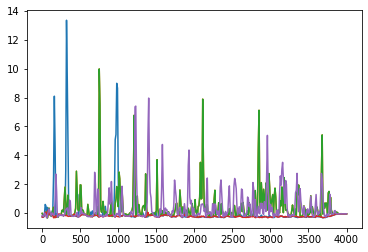

In [52]:
a=list(range(0,4010,10))
plt.plot(a,testFeatures[3601])
plt.plot(a,trainFeatures[3601])
plt.plot(a,trainFeatures[3601])
plt.plot(a,trainFeatures[4000])
plt.plot(a,trainFeatures[8000])
plt.show()
plt.show()


This function implements majority voting scheme. It assumes all cell phones record an equal amount of data during a test, and assumes the class with the most votes is the correct class.

[3379, 1609, 5774, 318, 1294]
Average amount of phones classifying accurately at any given time: 6.280669144981412
Accurately detected: 0.37732342007434944


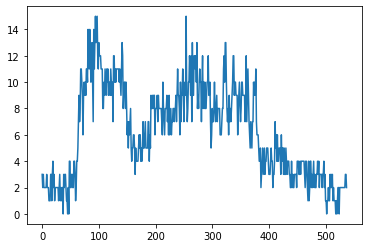

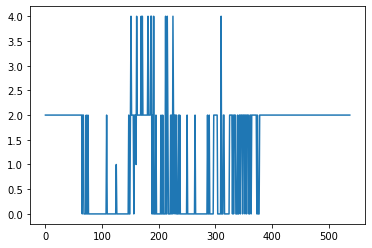

In [36]:
def majorityVote(testFeats, testTruth, numPhones, y_pred):
    samplesPerPhone=len(testFeats)/numPhones
    i=0
    correct=0
    correctOverTime=[]
    classPrediction=[]
    IFTot,MatriceTot,MavicTot,PhantomTot,NoiseTot=0,0,0,0,0
    for i in range(int(samplesPerPhone-1)):
        IF,Matrice,Mavic,Phantom,Noise=0,0,0,0,0
        for phone in range(numPhones):
            val=i+phone*int(samplesPerPhone)
            if y_pred[val].tolist()==[1,0,0,0,0]:
                IF+=1
                IFTot+=1
            elif y_pred[val].tolist()==[0,1,0,0,0]:
                Matrice+=1
                MatriceTot+=1
            elif y_pred[val].tolist()==[0,0,1,0,0]:
                Mavic+=1
                MavicTot+=1
            elif y_pred[val].tolist()==[0,0,0,1,0]:
                Phantom+=1
                PhantomTot+=1
            elif y_pred[val].tolist()==[0,0,0,0,1]:
                Noise+=1
                NoiseTot+=1
        valueList=[IF,Matrice,Mavic,Noise,Phantom]
        if np.argmax(valueList) == testTruth:
            correct+=1
        correctOverTime.append(valueList[testTruth])
        classPrediction.append(np.argmax(valueList))
    totCounts=[IFTot,MatriceTot,MavicTot,NoiseTot,PhantomTot]
    return correct, correctOverTime, classPrediction, totCounts

def create_test_dataset(test_files, testTime):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    features = []
    labels = []
    numPhones=0
    for x in test_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if len(test_audio) >= (testTime)*sampleRate and min(np.asarray(test_audio)) != 0: #ensure data actually has sound and recorded correctly
            numPhones+=1
            x = str(x)
            label = x.split('\\')
            label = label[6]
            #test_audio = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
            test_audio = test_audio[0: (testTime-1)*sampleRate]  # trim to nearest second
            #test_audio = test_audio[round(testTime/3)*sampleRate: round(testTime)*sampleRate]  # trim to nearest second
            newFeats, newLabs = split_test_audio(test_audio, label, int(sampleRate), chunk_size)
            features.extend(newFeats)
            labels.extend(newLabs)

    return features, labels,numPhones

dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A2\\A2R2P2"
Testdata_dir = pathlib.Path(dataset_path)
phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')

testFeatures,testTargets, numPhones =create_test_dataset(phones, 55)
testFeatures = np.asarray(testFeatures)
#testTargets = np.asarray(testTargets)
testFeatures -= mean
testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))
y_pred = np.argmax(network.predict(testFeatures), axis=1)
y_predict=[]
for x in y_pred:
    ans=np.zeros(5)
    ans[x]=1
    y_predict.append(ans)
amountCorrect, votingCount, classPrediction, totCounts = majorityVote(testFeatures,0,numPhones,y_predict)
print(totCounts)
print("Average amount of phones classifying accurately at any given time:", np.average(votingCount))
print("Accurately detected:", amountCorrect/len(votingCount))
plt.plot(range(len(votingCount)),votingCount)
plt.figure()
plt.plot(classPrediction)




